# **Unsupervised Learning**

## **K-Means**

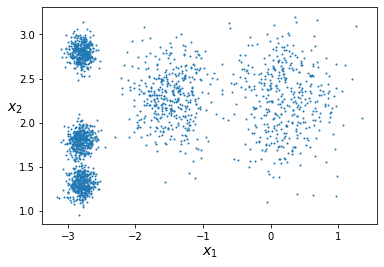

In [1]:
# let's start by generating some blobs
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

blob_centers = np.array([[0.2,  2.3], [-1.5,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)


def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


plot_clusters(X)


In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
y_predict = kmeans.fit_predict(X)
y_predict  # tiene los mismos valores que kmeans.labels_ despues de un .fit()


array([4, 0, 1, ..., 2, 1, 0])

In [3]:
# para obtener las coordenadas de los centros
kmeans.cluster_centers_


array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

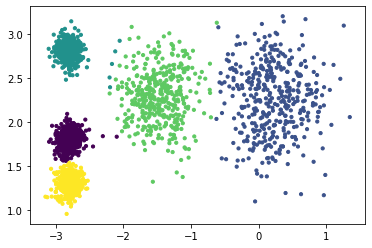

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_predict, s=10)


Let's plot the model's **decision boundaries**. This gives us a _Voronoi diagram_:


In [5]:

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='r'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):

    # obtener el rango de valores
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1

    # crear puntos de acuerdo a *resolucion* para colorear loa punto
    # de acuerdo al cluster que pertenece
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])

    # tener ya una array cuadrado de (resolucion,resolucion) asignado cada punto
    # a su cluster para poder hacer el contorno
    Z = Z.reshape(xx.shape)

    # mostrar el controno
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap="Pastel2")
    # mostrar los limites del contorno con unalinea negra
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')

    # mostrar los datos
    plot_data(X)
    if show_centroids:
        # mostrar los centroides
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


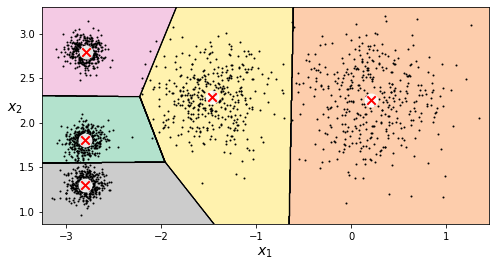

In [6]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()


Para saber la inertia de que es una métrica que mide la distancia media de cada instancia y su centroide 
(` NO ES UTIL PARA SELECCIOANR EL # OPTIMO K PQ A MEDIDA Q AUMENTA K DISMINUYE LA INERTIA `)

In [7]:
# el signo negativo es pq por defecto sklearn mientras mayor es una puntuacion mejor es el predictor
kmeans.score(X)


-211.5985372581684

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

### Finding the optimal number of clusters

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be.

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $\frac{(b - a)}{\max(a, b)}$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [8]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)


0.655517642572828

In [9]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]


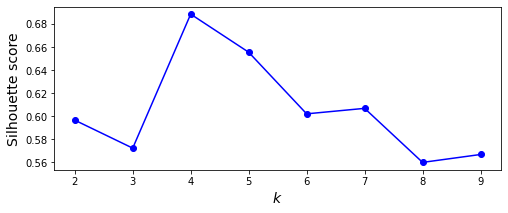

In [10]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()


As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

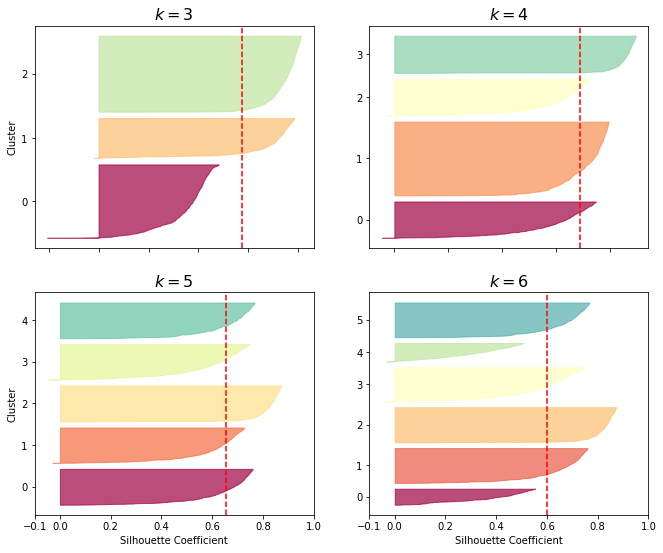

In [11]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()


As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

## **Mini-Batch K-Means**
Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [12]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)


MiniBatchKMeans(n_clusters=5, random_state=42)

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [13]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)


Next, let's write it to a `memmap`:

In [15]:
filename = "resources/my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train


In [16]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [17]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]


Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [18]:
np.random.seed(42)
k = 5
n_init = 10
n_iterations = 50  # usually 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
            minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

best_kmeans.score(X)


-211.8385015120745

Mini-batch K-Means is much faster than regular K-Means:

In [19]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)


63.3 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)


88 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases.

## **Using Clustering for Image Segmentation**

In [21]:
# # Download the ladybug image
import os
import urllib.request


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join('resources', filename))


('resources\\ladybug.png', <http.client.HTTPMessage at 0x20f42adada0>)

In [22]:
from matplotlib.image import imread
image = imread(os.path.join('resources', filename))
image.shape


(533, 800, 3)

In [23]:
X = image.reshape(-1, 3)
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

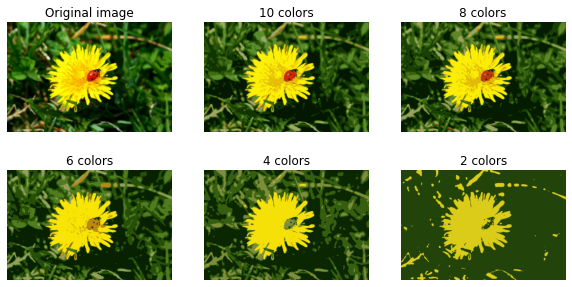

In [24]:
plt.figure(figsize=(10, 5))
# plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()


## **Using Clustering for Preprocessing(Dimension reduction)**

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)



Now let's fit a Logistic Regression model and evaluate it on the test set:

In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)


0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeline = Pipeline(
    [("kmeans", KMeans(n_clusters=50, random_state=42)),  # trasform()
     ("log_reg",
      LogisticRegression(
          multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)), ])
pipeline.fit(X_train, y_train)  # fit()


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [5]:
pipeline.score(X_test, y_test)

0.9777777777777777

How about that? We reduced the error rate by over 35%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.
 
 **Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.


In [6]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = dict(kmeans__n_clusters=range(40, 100))
grid_clf = RandomizedSearchCV(pipeline, param_grid, n_iter=20, n_jobs=-1, cv=3, verbose=1)
grid_clf.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('kmeans',
                                              KMeans(n_clusters=50,
                                                     random_state=42)),
                                             ('log_reg',
                                              LogisticRegression(max_iter=5000,
                                                                 multi_class='ovr',
                                                                 random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'kmeans__n_clusters': range(40, 100)},
                   verbose=1)

Let's see what the best number of clusters is:

In [7]:
grid_clf.best_params_

{'kmeans__n_clusters': 96}

In [8]:
grid_clf.score(X_test, y_test)

0.9822222222222222

## **Using Clustering for Semi-Supervised Learning**

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.
 
 Let's look at the performance of a logistic regression model when we only have 50 labeled instances at the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [4]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Para intentar mejorar la puntuacion dividamos el conjunto de entrenamiento en 50 grupos. Para cada
grupo, busquemos la imagen más cercana al centroide. A estas imágenes las llamaremos imágenes representativas

In [6]:
from sklearn.cluster import KMeans
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)

X_digits_dist = kmeans.fit_transform(X_train)

# buscar el indice de la instancia mas cercana a cada cluster
representative_digit_idx = np.argmin(X_digits_dist, axis=0)

# la instancia(en este caso digito) mas representativa de cada cluster
X_representative_digits = X_train[representative_digit_idx]

Veamos cada imagen y etiquetémosla manualmente:

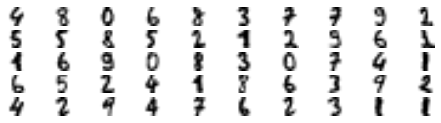

In [7]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8,8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [8]:
y_representative_digits = np.array(
    [4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
     5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
     1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
     6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
     4, 2, 9, 4, 7, 6, 2, 3, 1, 1])


Ahora tenemos un conjunto de datos con sólo 50 instancias etiquetadas,
pero en lugar de ser instancias aleatorias, cada una de ellas es una
imagen representativa de su clúster.

Veamos si el rendimiento es mejor:

In [9]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

¡Vaya! Hemos pasado de una precisión del 83,3% al 92,2%, aunque
todavía sólo estamos entrenando el modelo con 50 instancias. Dado que
a menudo es costoso y doloroso etiquetar instancias, especialmente
cuando lo tienen que hacer manualmente expertos, es una buena idea
etiquetar instancias representativas en lugar de instancias aleatorias.

### Label Propagation
¿y si propagamos las etiquetas a todas las demás instancias del mismo clúster?

In [10]:
# por ejemplo veamos en el primer cluster q tiene como digitos representativos
# cuantos digitos son verdaderamente 4
clust = kmeans.predict(X_train)
a0 = [cluster == 0 for cluster in clust]
y_train[a0]


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4])

In [11]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [12]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

Conseguimos un aumento razonable de la precisión, pero nada
absolutamente asombroso. El problema es que propagamos la etiqueta
de cada instancia representativa a todas las instancias del mismo clúster,
incluidas las instancias situadas cerca de los límites del clúster, que tienen
más probabilidades de estar mal etiquetadas.
 
We only propagate the labels to the 20% of the instances that are closest to the centroids

In [13]:
X_digits_dist = kmeans.fit_transform(X_train)

# obtener la distancia de cada instacia a su clusters 
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]



In [23]:
percentile_closest = 70
# trasformar las instancias de acuerdo con la distancia a cada cluster
X_digits_dist = kmeans.fit_transform(X_train)

# calcular la distancia de cada instancia a su cluster
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for nro_cluster in range(k):
    # obtener los indices del cluster nro i
    in_cluster = (kmeans.labels_ == nro_cluster)

    # obtener todas las distancias de cada instancia que pertenece al cluster i
    cluster_dist = X_cluster_dist[in_cluster]
    
    # calcular la distancia del porcentile descrito 
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    
    # obtener las instancias que estan fuera del porcentile
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

Cantida de instancias prpagadas y que son incorrectas 

In [24]:
np.sum(y_train[partially_propagated] != y_train_propagated[partially_propagated])


22

In [25]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [26]:
log_reg.score(X_test, y_test)

0.9311111111111111

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 92.7% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [27]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9765708200212992

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

In [64]:
# instancias de entrenamiento que se clasificaron con una prob < 0.80
np.argwhere(np.max(log_reg.predict_proba(X_train), axis=1) < 0.8).shape


(80, 1)